In [1]:
"""
Train shallow neural networks on a synthetic classification dataset using convex optimization.
"""

import sys
sys.path.append("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from convex_nn.private.utils.data import gen_classification_data


from convex_nn.models import ConvexGatedReLU, ConvexReLU
from convex_nn.solvers import RFISTA, AL, LeastSquaresSolver, CVXPYSolver, ApproximateConeDecomposition
from convex_nn.regularizers import NeuronGL1, L2, L1
from convex_nn.metrics import Metrics
from convex_nn.activations import sample_gate_vectors
from convex_nn.optimize import optimize_model, optimize

In [3]:
# Generate realizable synthetic classification problem (ie. Figure 1)
n_train = 1000
n_test = 1000
d = 50
hidden_units = 100
kappa = 10  # condition number

(X_train, y_train), (X_test, y_test) = gen_classification_data(123, n_train, n_test, d, hidden_units, kappa)

In [4]:
lam = 0.001
max_neurons = 500
G = sample_gate_vectors(123, d, max_neurons)
metrics = Metrics(metric_freq=25, model_loss=True, train_accuracy=True, train_mse=True, test_mse=True, test_accuracy=True, neuron_sparsity=True)

In [5]:
model, _ = optimize("gated_relu", 
                          max_neurons, 
                          X_train, 
                          y_train, 
                          X_test, 
                          y_test,
                          regularizer = NeuronGL1(0.01),
                          verbose=True,  
                          device="cpu")

INFO:convex_nn:Pre-Optimization Metrics: Train Set objective: 0.5, Train Set grad_norm: 0.007702792529016733, 


fista:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:Termination criterion satisfied at iteration 20/10000. Exiting optimization loop.
INFO:convex_nn:Post-Optimization Metrics: Train Set objective: 0.4586989536285401, Train Set grad_norm: 9.152432767223218e-07, 


Train Set objective: 0.5, Train Set grad_norm: 0.007702792529016733, 


In [6]:
# Instantiate convex model and other options.
model = ConvexGatedReLU(G)
solver = RFISTA(model, tol=1e-8)
regularizer = NeuronGL1(0.01)

In [7]:
grelu_model, grelu_metrics = optimize_model(
    model,
    solver,
    metrics,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    regularizer=L2(0.001),
    verbose=True,
)

INFO:convex_nn:Pre-Optimization Metrics: Train Set objective: 0.5, Train Set grad_norm: 0.09645780175924301, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set squared_error: 1.0, Test Set nc_accuracy: 0.0, Test Set nc_squared_error: 1.0, group_sparsity: 1.0, 


fista:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.5, Train Set grad_norm: 0.09645780175924301, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set squared_error: 1.0, Test Set nc_accuracy: 0.0, Test Set nc_squared_error: 1.0, group_sparsity: 1.0, 
Train Set objective: 0.024476349353790283, Train Set grad_norm: 9.197350664180703e-06, Train Set base_objective: 0.024476349353790283, Train Set accuracy: 1.0, Train Set squared_error: 0.007742962837219238, Test Set nc_accuracy: 0.934, Test Set nc_squared_error: 0.23453570556640624, group_sparsity: 0.0, 


INFO:convex_nn:Termination criterion satisfied at iteration 51/10000. Exiting optimization loop.
INFO:convex_nn:Post-Optimization Metrics: Train Set objective: 0.023809797286987306, Train Set grad_norm: 9.665082068011088e-09, Train Set base_objective: 0.023809797286987306, Train Set accuracy: 1.0, Train Set squared_error: 0.009328636169433593, Test Set nc_accuracy: 0.936, Test Set nc_squared_error: 0.23129983520507813, group_sparsity: 0.0, 


Train Set objective: 0.023810088634490967, Train Set grad_norm: 1.243412484086548e-08, Train Set base_objective: 0.023810088634490967, Train Set accuracy: 1.0, Train Set squared_error: 0.009348078727722168, Test Set nc_accuracy: 0.936, Test Set nc_squared_error: 0.23128826904296876, group_sparsity: 0.0, 


In [8]:
# Training Accuracy
np.sum(np.sign(grelu_model(X_train)) == y_train) / len(y_train)

1.0

In [9]:
model = ConvexGatedReLU(G) # start with a Gated ReLU model; a ReLU model will be output.
solver = ApproximateConeDecomposition(model)
cd_model, cd_metrics = optimize_model(
    model,
    solver,
    metrics,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    regularizer,
    verbose=True,
)

INFO:convex_nn:Pre-Optimization Metrics: Train Set objective: 0.5, Train Set grad_norm: 0.00788937509059906, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set squared_error: 1.0, Test Set nc_accuracy: 0.0, Test Set nc_squared_error: 1.0, group_sparsity: 1.0, 


fista:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.5, Train Set grad_norm: 0.00788937509059906, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set squared_error: 1.0, Test Set nc_accuracy: 0.0, Test Set nc_squared_error: 1.0, group_sparsity: 1.0, 


INFO:convex_nn:Termination criterion satisfied at iteration 19/10000. Exiting optimization loop.
/Users/amishkin/Documents/projects/opt_convex_nn/convex_nn/src/convex_nn/private/models/regularizers/group_l1.py:80: RuntimeWarning: divide by zero encountered in true_divide
  * lab.smin(self.lam / grad_norms, 1)
INFO:convex_nn:Pre-Optimization Metrics: Train Set objective: 0.09053484350442886, Train Set grad_norm: 0.052663207054138184, 


quadratic_decomp:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.09053484350442886, Train Set grad_norm: 0.052663207054138184, 
Train Set objective: 0.0069370917658509255, Train Set grad_norm: 9.772692465048749e-06, 
Train Set objective: 0.0013574508277814507, Train Set grad_norm: 7.918126812000992e-07, 
Train Set objective: 0.00024084887917228938, Train Set grad_norm: 9.696704950101775e-08, 
Train Set objective: 2.5661798121462763e-05, Train Set grad_norm: 1.4304522011343579e-08, 
Train Set objective: 3.5166150444390717e-06, Train Set grad_norm: 1.4524431657392256e-09, 


INFO:convex_nn:Termination criterion satisfied at iteration 156/10000. Exiting optimization loop.
INFO:convex_nn:Post-Optimization Metrics: Train Set objective: 5.3888765306643835e-08, Train Set grad_norm: 8.905740034315102e-11, 
INFO:convex_nn:Post-Optimization Metrics: Train Set objective: 2.235670292571515, Train Set grad_norm: 0.02402445860207081, Train Set base_objective: 2.2356702880859376, Train Set accuracy: 0.954, Train Set squared_error: 0.5963451538085938, Test Set nc_accuracy: 0.927, Test Set nc_squared_error: 0.6597618408203125, group_sparsity: 0.876, 


Train Set objective: 2.3694464121212368e-07, Train Set grad_norm: 2.3102034174549146e-10, 


In [10]:
# Training Accuracy
np.sum(np.sign(cd_model(X_train)) == y_train) / len(y_train)

0.911

In [11]:
model = ConvexReLU(G)
solver = AL(model)
relu_model, relu_metrics = optimize_model(
    model,
    solver,
    metrics,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    regularizer,
    verbose=True,
)

INFO:convex_nn:Pre-Optimization Metrics: Train Set objective: 0.5, Train Set grad_norm: 0.01577875018119812, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set squared_error: 1.0, Test Set nc_accuracy: 0.0, Test Set nc_squared_error: 1.0, group_sparsity: 1.0, 


Outer al:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.5, Train Set grad_norm: 0.01577875018119812, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set squared_error: 1.0, Test Set nc_accuracy: 0.0, Test Set nc_squared_error: 1.0, group_sparsity: 1.0, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 6/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4770087515804916, Train Set grad_norm: 0.0007291387883014977, Train Set base_objective: 0.4744866981506347, Train Set accuracy: 0.949, Train Set squared_error: 0.7674247436523437, Test Set nc_accuracy: 0.918, Test Set nc_squared_error: 0.7938717041015625, group_sparsity: 0.01, 
Train Set objective: 0.4700453943833709, Train Set grad_norm: 1.389190128975315e-05, Train Set base_objective: 0.46671931457519533, Train Set accuracy: 0.918, Train Set squared_error: 0.6692890014648437, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.6988060302734375, group_sparsity: 0.312, 
Train Set objective: 0.46843211869150403, Train Set grad_norm: 4.16083230447839e-06, Train Set base_objective: 0.46539197540283206, Train Set accuracy: 0.917, Train Set squared_error: 0.6568297119140625, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.6902406005859375, group_sparsity: 0.429, 
Train Set objective: 0.4678613796848804, Train Set grad_norm: 1.2052853435307043e-06, Trai

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 82/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.46779102499969305, Train Set grad_norm: 9.990371836465783e-07, Train Set base_objective: 0.46513530349731447, Train Set accuracy: 0.917, Train Set squared_error: 0.6533619995117188, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.6884429931640625, group_sparsity: 0.494, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 20/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4742579006329179, Train Set grad_norm: 9.834013781073736e-07, Train Set base_objective: 0.4684523849487305, Train Set accuracy: 0.911, Train Set squared_error: 0.6664827880859375, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.698767333984375, group_sparsity: 0.351, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 24/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.47855344676971434, Train Set grad_norm: 9.85095198302588e-07, Train Set base_objective: 0.4700289096832275, Train Set accuracy: 0.911, Train Set squared_error: 0.6747822265625, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.705958984375, group_sparsity: 0.294, 
Train Set objective: 0.48177510479837654, Train Set grad_norm: 1.6533688267372781e-06, Train Set base_objective: 0.47104941940307615, Train Set accuracy: 0.911, Train Set squared_error: 0.680114013671875, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7106949462890625, group_sparsity: 0.292, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 37/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4816441153362393, Train Set grad_norm: 9.850181186266127e-07, Train Set base_objective: 0.471045331954956, Train Set accuracy: 0.911, Train Set squared_error: 0.6797079467773437, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7107447509765625, group_sparsity: 0.264, 
Train Set objective: 0.48393610364198686, Train Set grad_norm: 1.2986117781110806e-06, Train Set base_objective: 0.4717357406616211, Train Set accuracy: 0.911, Train Set squared_error: 0.6825093383789063, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7134006958007812, group_sparsity: 0.299, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 39/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.483798523902893, Train Set grad_norm: 9.75822104010149e-07, Train Set base_objective: 0.4717301330566406, Train Set accuracy: 0.911, Train Set squared_error: 0.68201708984375, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.713252685546875, group_sparsity: 0.377, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 24/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.48538213536888364, Train Set grad_norm: 9.802422482607653e-07, Train Set base_objective: 0.4721988983154297, Train Set accuracy: 0.911, Train Set squared_error: 0.683091796875, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7145037231445313, group_sparsity: 0.328, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 6/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4866302904039621, Train Set grad_norm: 9.728136092235218e-07, Train Set base_objective: 0.47239357757568357, Train Set accuracy: 0.911, Train Set squared_error: 0.683841796875, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7153092041015625, group_sparsity: 0.257, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 7/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4877547598034143, Train Set grad_norm: 9.790741160031757e-07, Train Set base_objective: 0.47267331504821775, Train Set accuracy: 0.911, Train Set squared_error: 0.6843211059570312, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7156455688476563, group_sparsity: 0.256, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 6/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4886576557606459, Train Set grad_norm: 9.723468110678368e-07, Train Set base_objective: 0.4728905601501465, Train Set accuracy: 0.911, Train Set squared_error: 0.6847244873046875, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7161419677734375, group_sparsity: 0.25, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 6/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.48938000285625455, Train Set grad_norm: 9.960041325030033e-07, Train Set base_objective: 0.473054365158081, Train Set accuracy: 0.911, Train Set squared_error: 0.685060546875, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7164835205078125, group_sparsity: 0.257, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 7/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.48995727208256723, Train Set grad_norm: 8.983249131233606e-07, Train Set base_objective: 0.47319416236877443, Train Set accuracy: 0.911, Train Set squared_error: 0.6853885498046876, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7168604736328125, group_sparsity: 0.467, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 8/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 0/10000. Exiting *inner* optimization loop.


Train Set objective: 0.4903743496388197, Train Set grad_norm: 8.038034025048546e-07, Train Set base_objective: 0.4733181247711182, Train Set accuracy: 0.911, Train Set squared_error: 0.6845775146484375, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7162703857421875, group_sparsity: 0.851, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 1/10000. Exiting *inner* optimization loop.


Train Set objective: 0.4903743496388197, Train Set grad_norm: 8.038034025048546e-07, Train Set base_objective: 0.4733181247711182, Train Set accuracy: 0.911, Train Set squared_error: 0.6845775146484375, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7162703857421875, group_sparsity: 0.851, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.49104410943388943, Train Set grad_norm: 8.591036930738483e-07, Train Set base_objective: 0.473384449005127, Train Set accuracy: 0.911, Train Set squared_error: 0.6846243896484375, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7163038330078125, group_sparsity: 0.952, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 6/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 0/10000. Exiting *inner* optimization loop.


Train Set objective: 0.49129932135343557, Train Set grad_norm: 7.443230742865126e-07, Train Set base_objective: 0.47346812248229986, Train Set accuracy: 0.911, Train Set squared_error: 0.6837911987304688, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7156347045898438, group_sparsity: 0.957, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 0/10000. Exiting *inner* optimization loop.


Train Set objective: 0.49129932135343557, Train Set grad_norm: 7.443230742865126e-07, Train Set base_objective: 0.47346812248229986, Train Set accuracy: 0.911, Train Set squared_error: 0.6837911987304688, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7156347045898438, group_sparsity: 0.957, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.49129932135343557, Train Set grad_norm: 7.443230742865126e-07, Train Set base_objective: 0.47346812248229986, Train Set accuracy: 0.911, Train Set squared_error: 0.6837911987304688, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7156347045898438, group_sparsity: 0.957, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 1/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 0/10000. Exiting *inner* optimization loop.


Train Set objective: 0.49190025731921194, Train Set grad_norm: 7.643031381121546e-07, Train Set base_objective: 0.47352478981018065, Train Set accuracy: 0.911, Train Set squared_error: 0.6838247680664062, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7156709594726562, group_sparsity: 0.958, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Inner* termination criterion satisfied at iteration 1/10000. Exiting *inner* optimization loop.


Train Set objective: 0.49190025731921194, Train Set grad_norm: 7.643031381121546e-07, Train Set base_objective: 0.47352478981018065, Train Set accuracy: 0.911, Train Set squared_error: 0.6838247680664062, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7156709594726562, group_sparsity: 0.958, 


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.4922444367259741, Train Set grad_norm: 9.140172778643318e-07, Train Set base_objective: 0.47355323410034184, Train Set accuracy: 0.911, Train Set squared_error: 0.6837880249023438, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.715649658203125, group_sparsity: 0.961, 


INFO:convex_nn:*Inner* termination criterion satisfied at iteration 3/10000. Exiting *inner* optimization loop.


Inner al:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:convex_nn:*Outer* termination criterion satisfied at iteration 22/10000. Exiting *outer* optimization loop.


Train Set objective: 0.49238505551218986, Train Set grad_norm: 8.664882216180558e-07, Train Set base_objective: 0.4736156311035156, Train Set accuracy: 0.911, Train Set squared_error: 0.6835282592773437, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7154508056640625, group_sparsity: 0.961, 


INFO:convex_nn:Post-Optimization Metrics: Train Set objective: 0.49247168764472005, Train Set grad_norm: 6.800977416787646e-07, Train Set base_objective: 0.4736297988891601, Train Set accuracy: 0.911, Train Set squared_error: 0.6832611083984375, Test Set nc_accuracy: 0.914, Test Set nc_squared_error: 0.7152445678710937, group_sparsity: 0.962, 


In [12]:
# Training Accuracy
np.sum(np.sign(relu_model(X_train)) == y_train) / len(y_train)

0.911

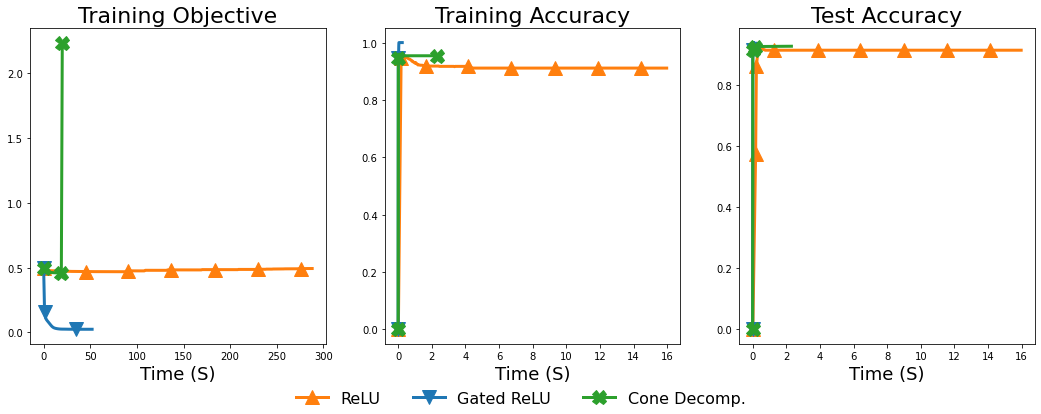

In [13]:
fig = plt.figure(figsize=(18,6))
spec = fig.add_gridspec(ncols=3, nrows=1)
ax0 = fig.add_subplot(spec[0, 0])

ax0.plot(np.arange(len(relu_metrics.objective)), 
         relu_metrics.objective, 
         label="ReLU", 
         color="#ff7f0e",
         marker="^",
         markevery=0.1,
         markersize=14,
         linewidth="3")

ax0.plot(np.arange(len(grelu_metrics.objective)), 
         grelu_metrics.objective, 
         label="Gated ReLU", 
         color="#1f77b4",
         marker="v", 
         markevery=0.1,
         markersize=14,
         linewidth="3"
        )

ax0.plot(np.arange(len(cd_metrics.objective)), 
         cd_metrics.objective, 
         label="Cone Decomp.", 
         color="#2ca02c",
         marker="X", 
         markevery=0.1,
         markersize=14,
         linewidth="3"
        )

ax0.set_title("Training Objective", fontsize=22)
ax0.set_xlabel("Time (S)", fontsize=18)

ax1 = fig.add_subplot(spec[0, 1])

ax1.plot(relu_metrics.time, 
         relu_metrics.train_accuracy, 
         label="Relu", 
         color="#ff7f0e",
         marker="^",
         markevery=0.1,
         markersize=14,
         linewidth="3")

ax1.plot(grelu_metrics.time, 
         grelu_metrics.train_accuracy, 
         label="Gated ReLU", 
         color="#1f77b4",
         marker="v", 
         markevery=0.1,
         markersize=14,
         linewidth="3"
        )

ax1.plot(cd_metrics.time, 
         cd_metrics.train_accuracy, 
         label="Cone Decomp.", 
         color="#2ca02c",
         marker="X", 
         markevery=0.1,
         markersize=14,
         linewidth="3"
        )

ax1.set_title("Training Accuracy", fontsize=22)
ax1.set_xlabel("Time (S)", fontsize=18)

ax2 = fig.add_subplot(spec[0, 2])


ax2.plot(relu_metrics.time, 
         relu_metrics.test_accuracy, 
         label="Relu", 
         color="#ff7f0e",
         marker="^",
         markevery=0.1,
         markersize=14,
         linewidth="3")

ax2.plot(grelu_metrics.time, 
         grelu_metrics.test_accuracy, 
         label="Gated ReLU", 
         color="#1f77b4",
         marker="v", 
         markevery=0.1,
         markersize=14,
         linewidth="3"
        )

ax2.plot(cd_metrics.time, 
         cd_metrics.test_accuracy, 
         label="Cone Decomp.", 
         color="#2ca02c",
         marker="X", 
         markevery=0.1,
         markersize=14,
         linewidth="3"
        )

ax2.set_title("Test Accuracy", fontsize=22)
ax2.set_xlabel("Time (S)", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
legend = fig.legend(
    handles=handles,
    labels=labels,
    loc="lower center",
    borderaxespad=0.1,
    fancybox=False,
    shadow=False,
    ncol=3,
    fontsize=16,
    frameon=False,
)
fig.subplots_adjust(
    bottom=0.15,
)

In [14]:
# Super-fast least-squares solver.
model = ConvexGatedReLU(G)
solver = LeastSquaresSolver(model, tol=1e-8)
regularizer = L2(0.01)
lstsq_model, lstsq_metrics = optimize_model(
    model,
    solver,
    metrics,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    regularizer=regularizer,
    verbose=True,
)

INFO:convex_nn:Pre-Training Metrics: Train Set objective: 0.5, Train Set grad_norm: 0.09645780175924301, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set squared_error: 1.0, Test Set nc_accuracy: 0.0, Test Set nc_squared_error: 1.0, group_sparsity: 1.0, 
INFO:convex_nn:Post-Training Metrics: Train Set objective: 0.10596883459402834, Train Set grad_norm: 8.607546412607804e-16, Train Set base_objective: 0.10596883459402834, Train Set accuracy: 0.999, Train Set squared_error: 0.10412220648225343, Test Set nc_accuracy: 0.937, Test Set nc_squared_error: 0.2360975301259304, group_sparsity: 0.0, 


In [15]:
# Training Accuracy
np.sum(np.sign(lstsq_model(X_train)) == y_train) / len(y_train)

0.998

In [16]:
solver = CVXPYSolver(model, "mosek", clean_sol=True)

In [17]:
# Interior-point solver using CXVPY.
model = ConvexGatedReLU(G)
solver = CVXPYSolver(model, "mosek", clean_sol=True)
regularizer = NeuronGL1(0.01)
cvxpy_model, cvxpy_metrics = optimize_model(
    model,
    solver,
    metrics,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    regularizer=regularizer,
    verbose=True,
)

INFO:convex_nn:Pre-Training Metrics: Train Set objective: 0.5, Train Set grad_norm: 0.00788937509059906, Train Set base_objective: 0.5, Train Set accuracy: 0.0, Train Set squared_error: 1.0, Test Set nc_accuracy: 0.0, Test Set nc_squared_error: 1.0, group_sparsity: 1.0, 


                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Apr 06 05:14:09 PM: Your problem has 25000 variables, 0 constraints, and 0 parameters.
(CVXPY) Apr 06 05:14:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 06 05:14:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 06 05:14:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 06 05:14:09 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Apr 06 05:14:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

INFO:convex_nn:Post-Training Metrics: Train Set objective: 0.4567270374298096, Train Set grad_norm: 1.6603969588135925e-10, Train Set base_objective: 0.4567270374298096, Train Set accuracy: 0.95, Train Set squared_error: 0.595386962890625, Test Set nc_accuracy: 0.915, Test Set nc_squared_error: 0.6591937866210937, group_sparsity: 0.954, 
